<a href="https://colab.research.google.com/github/jihyuk1023/AI_physics/blob/main/09_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer Learning 이란, 이미 학습된 모델의 weight와 bias들을 가져와서 새로운 데이터들로 이 모델을 다시 학습시키는 것입니다.
Transfer Learning 은 주어진 데이터셋이 충분히 크지 않을 경우 사용하는 학습 방법입니다. 다른 데이터셋에서(이 데이터셋과 관련된) 이미 비슷한 feature들을 학습했을 것이라고 가정하고, parameter들을 조금씩 학습시키는 방법입니다.

우리는 ResNet에 대해서 배웠습니다. ImageNet 학습 모델이 파이토치에 저장되어 있습니다. 이 모델을 가져와 visualization 해보겠습니다.

ImageNet이란, CIFAR32와 같은 이미지 데이터지만, 고해상도의 이미지 파일입니다. 따라서, 용량이 매우 크고 데이터셋 자체도 크기때문에 torchvision에 내장되어 있지 않고 따로 다운로드 받아서 써야 합니다.

우리는 ImageNet의 일부인 개미와 벌 구분 모델을 훈련시킬 것입니다. (비슷한 모델이 여러개 있습니다. 예를들어, ImageNet에는 개와 고양이 사진들도 많이 있으므로 개와 고양이 사진을 가지고 Transfer Learning을 시도할 수도 있습니다. 아래는 이 데이터셋을 구할 수 있는 경로입니다.(https://www.kaggle.com/c/dogs-vs-cats/data, 캐글 회원가입이 필요합니다.)

일반적으로 데이터셋이 작을 경우에는 학습이 잘 되지 않습니다. 그러나, 이미 학습된 모델을 사용한다면 fully connected network만 학습해도 좋은 결과를 얻을 수 있습니다.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

ImageNet 학습을 위한 ResNet을 불러옵니다. pretrained = True로 설정하면, 이미 학습된 파라미터들을 불러올 수 있습니다.

In [ ]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


첫 번째 층 필터들은 아래와 같이 확인할 수 있습니다.

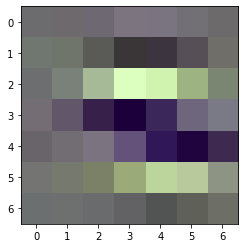

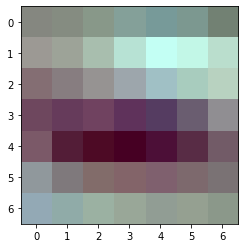

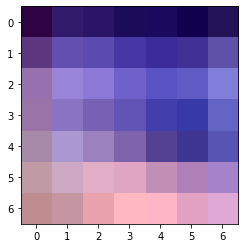

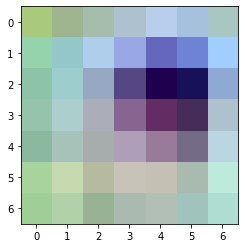

In [ ]:
for i in range(4):
  parameter = (list(model_ft.conv1.parameters())[0][i]).detach().numpy().transpose([1,2,0])
  parameter = parameter - np.min(parameter)
  parameter = parameter / np.max(parameter)
  plt.imshow(parameter)
  plt.show()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

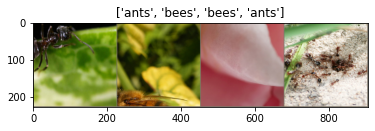

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # tensor -> (filter, x, y) / numpy -> (x, y, filter)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

#이미  학습된  파라미터들에 대해서 새로운 정보가 들어왔을 때 

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6337 Acc: 0.659836
val Loss: 0.6323 Acc: 0.679739

Epoch 1/24
----------
train Loss: 0.5091 Acc: 0.786885
val Loss: 0.2332 Acc: 0.901961

Epoch 2/24
----------
train Loss: 0.4995 Acc: 0.778689
val Loss: 0.2544 Acc: 0.915033

Epoch 3/24
----------
train Loss: 0.4761 Acc: 0.803279
val Loss: 0.2394 Acc: 0.915033

Epoch 4/24
----------
train Loss: 0.3635 Acc: 0.856557
val Loss: 0.1633 Acc: 0.934641

Epoch 5/24
----------
train Loss: 0.4775 Acc: 0.799180
val Loss: 0.1485 Acc: 0.960784

Epoch 6/24
----------
train Loss: 0.3795 Acc: 0.831967
val Loss: 0.1435 Acc: 0.973856

Epoch 7/24
----------
train Loss: 0.4500 Acc: 0.827869
val Loss: 0.1559 Acc: 0.960784

Epoch 8/24
----------
train Loss: 0.4812 Acc: 0.790984
val Loss: 0.1771 Acc: 0.941176

Epoch 9/24
----------
train Loss: 0.3513 Acc: 0.823770
val Loss: 0.1451 Acc: 0.960784

Epoch 10/24
----------
train Loss: 0.2981 Acc: 0.872951
val Loss: 0.1460 Acc: 0.967320

Epoch 11/24
----------
train Loss: 0.3350 Acc: 0.848361
val Loss

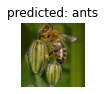

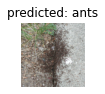

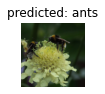

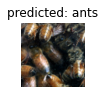

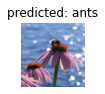

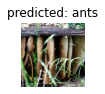

In [ ]:
visualize_model(model_ft)

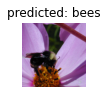

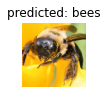

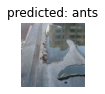

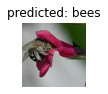

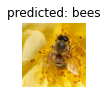

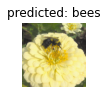

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()